## Image 2 Image

In [5]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler
from tqdm.auto import tqdm

logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()


In [6]:
from PIL import Image
from torchvision import transforms as tfms
from IPython.display import display

In [8]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

In [9]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

In [10]:
beta_start,beta_end = 0.00085,0.012
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [33]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to("cuda", dtype=torch.float16)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

In [54]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def mk_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

def mk_samples(prompts,init_image, g=8, seed=100, steps=70, neg_prompt=None):
    bs = len(prompts)
    text = text_enc(prompts)
    if not neg_prompt: 
        uncond = text_enc([""] * bs, text.shape[1])
    else:
        assert len(prompts) == len(neg_prompt)
        uncond =  text_enc(neg_prompt, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)
    
    scheduler.set_timesteps(steps)
    
    encoded = pil_to_latent(init_image)
    start_step = 5
    start_sigma = scheduler.sigmas[start_step]
    noise = torch.randn_like(encoded)

    latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
    latents = latents.to("cuda").half()

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        if i >= start_step:
            inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
            with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
            pred = u + g*(t-u)
            latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62145  100 62145    0     0   415k      0 --:--:-- --:--:-- --:--:--  415k


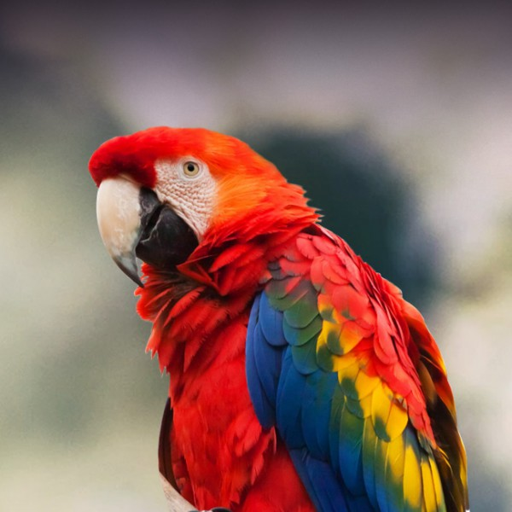

In [47]:
!curl --output macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'
input_image = Image.open('macaw.jpg').resize((512, 512))
input_image

## Example 1

In [48]:
prompts = ["A colorful dancer, nat geo photo"]
height = 512
width = 512
batch_size = 1

In [55]:
images = mk_samples(prompts, init_image=input_image)

  0%|          | 0/70 [00:00<?, ?it/s]

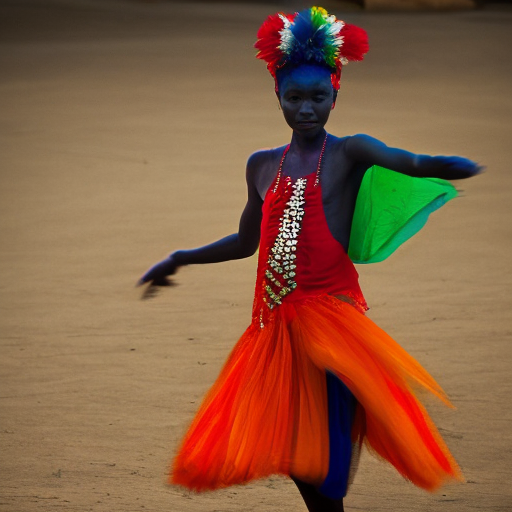

In [56]:
for img in images: display(mk_img(img))